## Import required libraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from wordcloud import WordCloud

## Data Collection

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
df = pd.read_csv("/content/drive/MyDrive/ANN/data.csv")


In [4]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


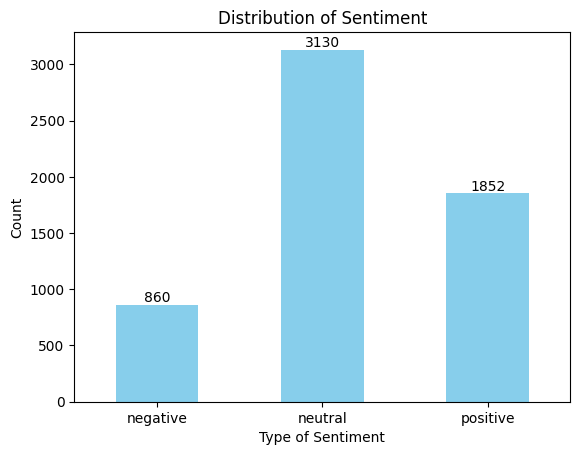

In [5]:
sentiment_counts = df['Sentiment'].value_counts().sort_index()
value = sentiment_counts.plot(kind='bar', color='skyblue')
for i in value.containers:
    value.bar_label(i)
plt.xlabel('Type of Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiment')
plt.xticks(rotation=0)
plt.show()

From this distribution, we can say that the data is not balanced.The neutral sentiment has highest values i.t 3130 and positive has 1852 and negative has least count i.e 860

In [47]:
df.shape

(5842, 2)

## Data Preprocessing

In [7]:
df.isnull().sum()

,0
Sentence,0
Sentiment,0


In this dataset, there is no null value.

In [8]:


df.describe()


,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


 This indicates that the dataset has 5842 entries with sentences and corresponding sentiments, with 5322 unique sentences and  3 unique sentiment categories, and the "neutral" sentiment being the most frequent.

In [9]:
df.duplicated().sum()

6

In [10]:
df[df.duplicated()]

,Sentence,Sentiment
1825,Proha Plc ( Euronext :7327 ) announced today (...,neutral
1859,SSH Communications Security Corporation is hea...,neutral
2672,Ahlstrom 's share is quoted on the NASDAQ OMX ...,neutral
3272,The company serves customers in various indust...,neutral
3986,The issuer is solely responsible for the conte...,neutral
5342,The report profiles 614 companies including ma...,neutral


In [11]:
df.drop_duplicates(subset=['Sentence'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5322 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5322 non-null   object
 1   Sentiment  5322 non-null   object
dtypes: object(2)
memory usage: 124.7+ KB


In [12]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


## Data Preprocessing

In [13]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = re.sub(r'@\w+', '', text) # Remove mentions
    text = re.sub(r'#(\w+)', r'\1', text)  #  # Remove hashtags but keep words attached to hashtags
    text = re.sub(r'[^\w\s-]', '', text)  # Remove special symbols but keep hyphens within words
    text = re.sub(r'(?<!\w)-|-(?!\w)', '', text)
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = text.lower().strip()  # Convert text to lowercase and remove leading/trailing whitespace
    text = ' '.join(word for word in text.split() if len(word) > 2) # remove words whose length is less than 2
    return text

In [14]:
df['cleaned_sentence'] = df['Sentence'].apply(clean_text)

## Label Encoding

In [15]:
label_encoder = LabelEncoder()
df['encoded_sentiment'] = label_encoder.fit_transform(df['Sentiment'])


In [17]:
df.head()

,Sentence,Sentiment,cleaned_sentence,encoded_sentiment
0,The GeoSolutions technology will leverage Bene...,positive,the geosolutions technology will leverage bene...,2
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,esi lows down real possibility,0
2,"For the last quarter of 2010 , Componenta 's n...",positive,for the last quarter componenta net sales doub...,2
3,According to the Finnish-Russian Chamber of Co...,neutral,according the finnish-russian chamber commerce...,1
4,The Swedish buyout firm has sold its remaining...,neutral,the swedish buyout firm has sold its remaining...,1


In [16]:
sentiment_counts = df[['Sentiment','encoded_sentiment']].drop_duplicates()
sentiment_counts

,Sentiment,encoded_sentiment
0,positive,2
1,negative,0
3,neutral,1


## Word Cloud

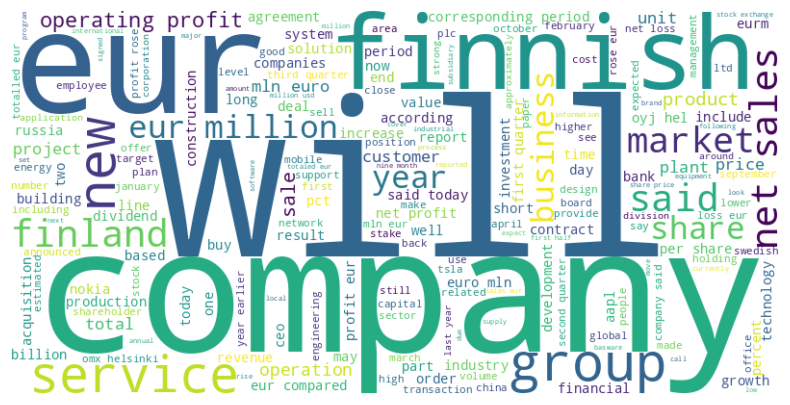

In [18]:
text = " ".join(sentence for sentence in df.cleaned_sentence)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Feature Engineering

### Text Tokenization

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_sentence'])
sequences = tokenizer.texts_to_sequences(df['cleaned_sentence'])


In [20]:
df['cleaned_sentence'][1]

'esi lows down real possibility'

In [21]:
sequences[1]

[4871, 1155, 45, 152, 3411]

### Padding

In [22]:
def max_sequence_length(lst):
    return max(len(sublist) for sublist in lst)

In [23]:
max_sequence_length(sequences)

46

In [24]:
# Pad the sequences
max_sequence_length = max_sequence_length(sequences)  # Set maximum sequence length
X = pad_sequences(sequences, maxlen=max_sequence_length)
y = df['encoded_sentiment']


In [51]:
X[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0, 4871, 1155,   45,
        152, 3411], dtype=int32)

## Train Test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=42)


## Build Simple RNN model

In [26]:
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
embedding_dim = 100  # Embedding dimensions
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(SimpleRNN(units=128))
model.add(Dropout(0.3))
model.add(Dense(units=3, activation='sigmoid'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_hist = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.1)

Epoch 1/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.4967 - loss: 0.9832 - val_accuracy: 0.6268 - val_loss: 0.8687
Epoch 2/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.7953 - loss: 0.5994 - val_accuracy: 0.6056 - val_loss: 0.9074
Epoch 3/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9565 - loss: 0.1515 - val_accuracy: 0.6244 - val_loss: 1.0265
Epoch 4/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9839 - loss: 0.0638 - val_accuracy: 0.6103 - val_loss: 1.2843
Epoch 5/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9921 - loss: 0.0365 - val_accuracy: 0.5775 - val_loss: 1.2578
Epoch 6/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9909 - loss: 0.0397 - val_accuracy: 0.5822 - val_loss: 1.2725
Epoch 7/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9922 - loss: 0.0269 - val_accuracy: 0.5986 - val_loss: 1.2814
Epoch 8/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9956 - loss: 0.0185 - val_acc

In [28]:
rnn_loss_per_epoch = model_hist.history['loss']
rnn_val_loss_per_epoch = model_hist.history['val_loss']

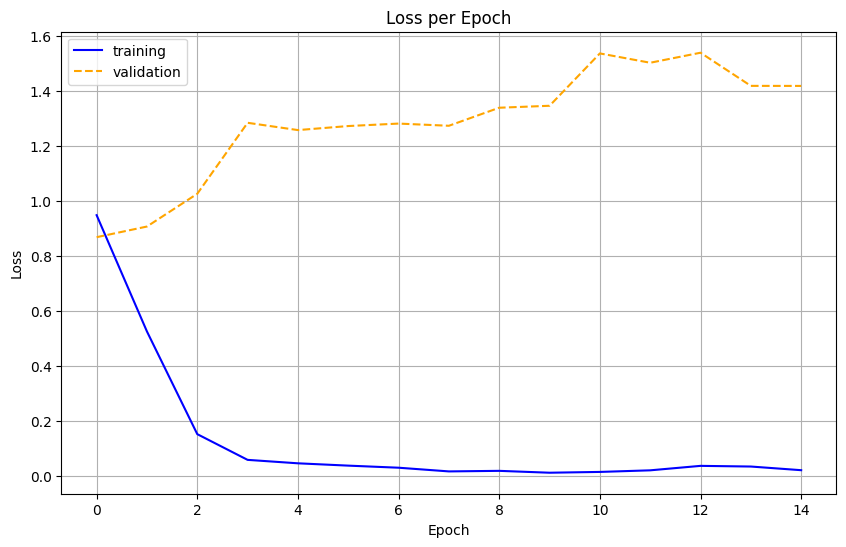

In [29]:
# Plot the training and validation loss per epoch
plt.figure(figsize=(10, 6))
plt.plot(rnn_loss_per_epoch, label='training', color='b')
plt.plot(rnn_val_loss_per_epoch, label='validation', linestyle='--', color='orange')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


print('Classification Report:')
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))
rnn_report_dict = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_, output_dict=True)
rnn_weighted_avg_metrics = rnn_report_dict['weighted avg']
rnn_weighted_avg_df = pd.DataFrame(rnn_weighted_avg_metrics, index=[0])
rnn_accuracy = accuracy_score(y_test, y_pred_classes)

rnn_weighted_avg_df['accuracy'] = rnn_accuracy



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Classification Report:
              precision    recall  f1-score   support

    negative       0.34      0.18      0.24       137
     neutral       0.65      0.73      0.69       550
    positive       0.55      0.55      0.55       378

    accuracy                           0.59      1065
   macro avg       0.51      0.49      0.49      1065
weighted avg       0.57      0.59      0.58      1065



## LSTM

In [32]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model_lstm.add(LSTM(units=128))
# model_lstm.add(LSTM(units=64))
model.add(Dropout(0.3))
model_lstm.add(Dense(units=3, activation='sigmoid'))

# Compile the model
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model
lstm_model_hist = model_lstm.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.1)
model_lstm.summary()

Epoch 1/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.5604 - loss: 0.9406 - val_accuracy: 0.6620 - val_loss: 0.7540
Epoch 2/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.7625 - loss: 0.5944 - val_accuracy: 0.7136 - val_loss: 0.6870
Epoch 3/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.8976 - loss: 0.2929 - val_accuracy: 0.7042 - val_loss: 0.8103
Epoch 4/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.9539 - loss: 0.1398 - val_accuracy: 0.7066 - val_loss: 0.9400
Epoch 5/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - accuracy: 0.9727 - loss: 0.0785 - val_accuracy: 0.7019 - val_loss: 1.2445
Epoch 6/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.9732 - loss: 0.0647 - val_accuracy: 0.7066 - val_loss: 1.2446
Epoch 7/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.9803 - loss: 0.0505 - val_accuracy: 0.7113 - val_loss: 1.2674
Epoch 8/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - accuracy: 0.9792 - loss: 0.0609 - 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 46, 100)             │         996,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,342,707 (12.75 MB)

 Trainable params: 1,114,235 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,228,472 (8.50 MB)

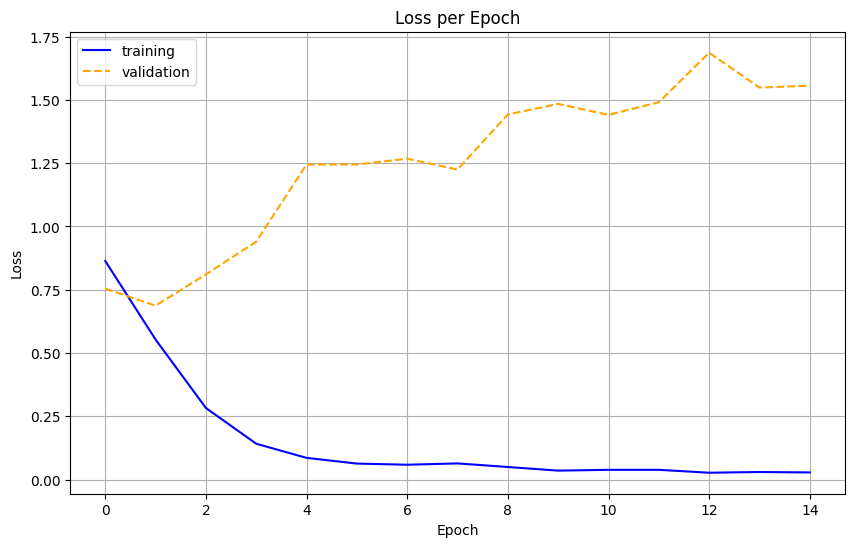

In [33]:
lstm_loss_per_epoch = lstm_model_hist.history['loss']
lstm_val_loss_per_epoch = lstm_model_hist.history['val_loss']
# Plot the training and validation loss per epoch
plt.figure(figsize=(10, 6))
plt.plot(lstm_loss_per_epoch, label='training', color='b')
plt.plot(lstm_val_loss_per_epoch, label='validation', linestyle='--', color='orange')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
y_pred_lstm = model_lstm.predict(X_test)
y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1)

# Print the classification report
print('Classification Report:')
print(classification_report(y_test, y_pred_classes_lstm, target_names=label_encoder.classes_))
lstm_report_dict = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_, output_dict=True)
lstm_weighted_avg_metrics = lstm_report_dict['weighted avg']
lstm_weighted_avg_df = pd.DataFrame(lstm_weighted_avg_metrics, index=[0])
lstm_accuracy = accuracy_score(y_test, y_pred_classes_lstm)

lstm_weighted_avg_df['accuracy'] = lstm_accuracy




34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Classification Report:
              precision    recall  f1-score   support

    negative       0.40      0.45      0.42       137
     neutral       0.79      0.78      0.78       550
    positive       0.75      0.72      0.74       378

    accuracy                           0.72      1065
   macro avg       0.65      0.65      0.65      1065
weighted avg       0.72      0.72      0.72      1065



## Bidirectional LSTM

In [35]:
from tensorflow.keras.layers import SpatialDropout1D


bi_model_lstm = Sequential()
bi_model_lstm.add(Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_sequence_length))

bi_model_lstm.add(SpatialDropout1D(0.3))

bi_model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=False)))
bi_model_lstm.add(Dense(units=3, activation='sigmoid'))

bi_model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [36]:
bi_model_lstm_hist = bi_model_lstm.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.1)
bi_model_lstm.summary()

Epoch 1/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.5580 - loss: 0.9399 - val_accuracy: 0.6526 - val_loss: 0.8035
Epoch 2/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.7654 - loss: 0.6206 - val_accuracy: 0.7066 - val_loss: 0.7554
Epoch 3/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.8436 - loss: 0.3952 - val_accuracy: 0.7207 - val_loss: 0.8353
Epoch 4/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9322 - loss: 0.2087 - val_accuracy: 0.7066 - val_loss: 0.9243
Epoch 5/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9554 - loss: 0.1247 - val_accuracy: 0.7183 - val_loss: 1.0244
Epoch 6/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.9775 - loss: 0.0782 - val_accuracy: 0.7066 - val_loss: 1.0891
Epoch 7/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9793 - loss: 0.0673 - val_accuracy: 0.6972 - val_loss: 1.1736
Epoch 8/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.9775 - loss: 0.0599 - va

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 46, 100)             │         996,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 46, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,244,403 (12.38 MB)

 Trainable params: 1,081,467 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,162,936 (8.25 MB)

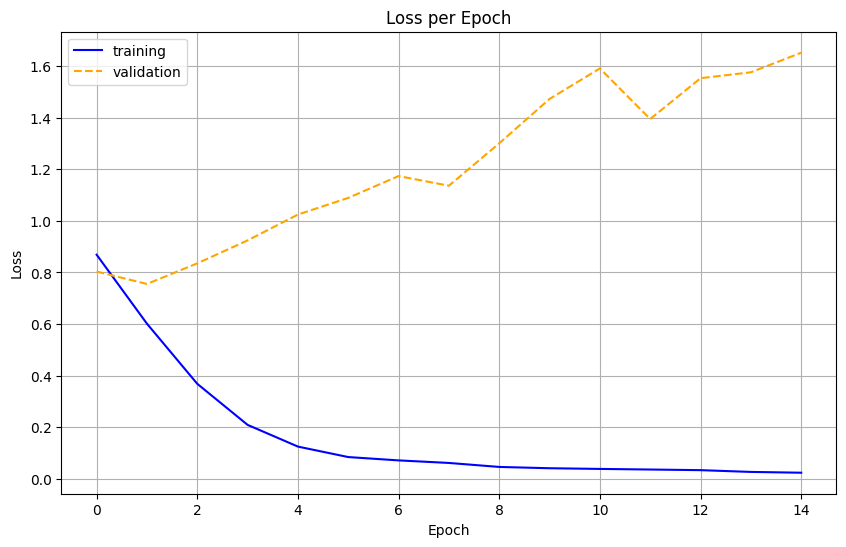

In [37]:
bi_lstm_loss_per_epoch = bi_model_lstm_hist.history['loss']
bi_lstm_val_loss_per_epoch = bi_model_lstm_hist.history['val_loss']
# Plot the training and validation loss per epoch
plt.figure(figsize=(10, 6))
plt.plot(bi_lstm_loss_per_epoch, label='training', color='b')
plt.plot(bi_lstm_val_loss_per_epoch, label='validation', linestyle='--', color='orange')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
y_pred_bi_lstm = bi_model_lstm.predict(X_test)
y_pred_classes_bi_lstm = np.argmax(y_pred_bi_lstm, axis=1)
print('Classification Report:')
print(classification_report(y_test, y_pred_classes_bi_lstm, target_names=label_encoder.classes_))
bi_lstm_report_dict = classification_report(y_test, y_pred_classes_bi_lstm, target_names=label_encoder.classes_, output_dict=True)
bi_lstm_weighted_avg_metrics = bi_lstm_report_dict['weighted avg']
bi_lstm_weighted_avg_df = pd.DataFrame(bi_lstm_weighted_avg_metrics, index=[0])
bi_lstm_accuracy = accuracy_score(y_test, y_pred_classes_bi_lstm)

bi_lstm_weighted_avg_df['accuracy'] = bi_lstm_accuracy



34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Classification Report:
              precision    recall  f1-score   support

    negative       0.46      0.45      0.45       137
     neutral       0.78      0.81      0.80       550
    positive       0.75      0.71      0.73       378

    accuracy                           0.73      1065
   macro avg       0.66      0.65      0.66      1065
weighted avg       0.73      0.73      0.73      1065



In [39]:
result = pd.concat([rnn_weighted_avg_df, lstm_weighted_avg_df, bi_lstm_weighted_avg_df], axis=0)

In [40]:
result['model']=['RNN','LSTM','Bi-LSTM']
result

,precision,recall,f1-score,support,accuracy,model
0,0.573969,0.592488,0.579202,1065.0,0.592488,RNN
0,0.573969,0.592488,0.579202,1065.0,0.717371,LSTM
0,0.726180,0.727700,0.726535,1065.0,0.727700,Bi-LSTM


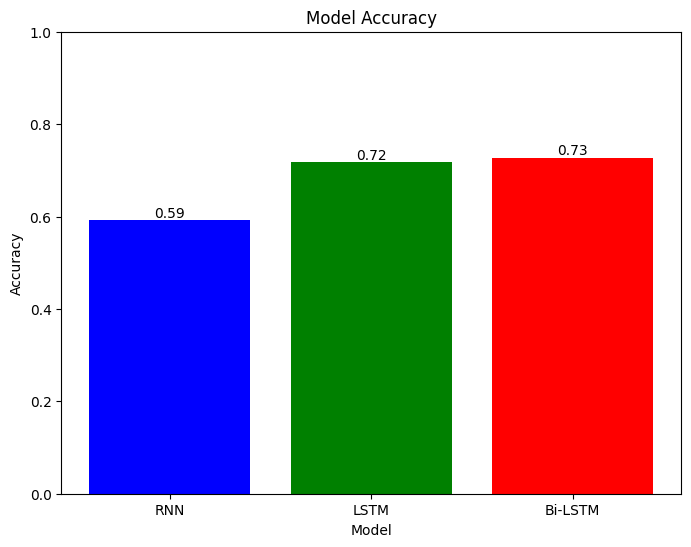

In [41]:
plt.figure(figsize=(8, 6))
bars = plt.bar(result['model'], result['accuracy'], color=['blue', 'green', 'red'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.ylim(0, 1)
plt.show()

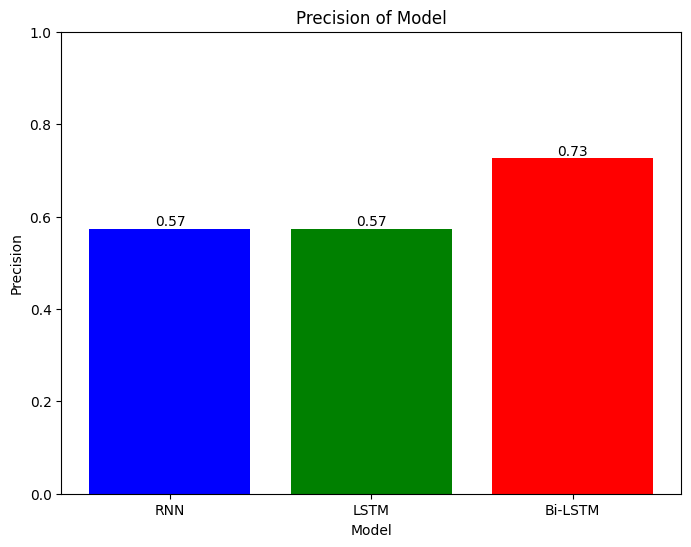

In [42]:
plt.figure(figsize=(8, 6))
bars = plt.bar(result['model'], result['precision'], color=['blue', 'green', 'red'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Precision of Model')
plt.ylim(0, 1)
plt.show()

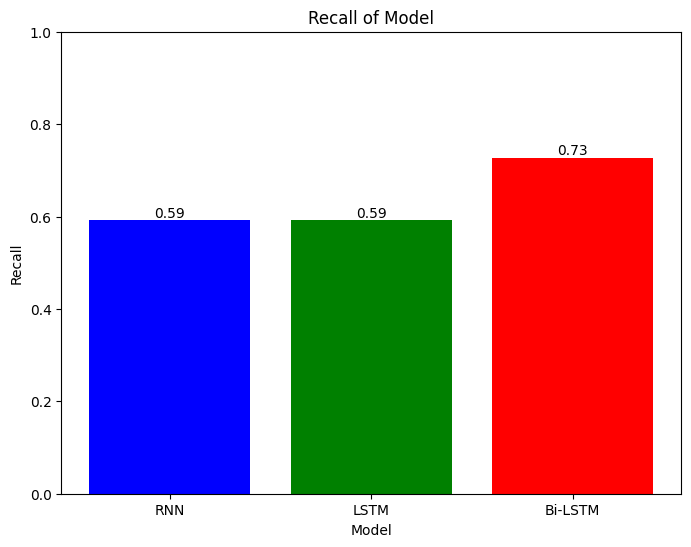

In [43]:
plt.figure(figsize=(8, 6))
bars = plt.bar(result['model'], result['recall'], color=['blue', 'green', 'red'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Recall of Model')
plt.ylim(0, 1)
plt.show()

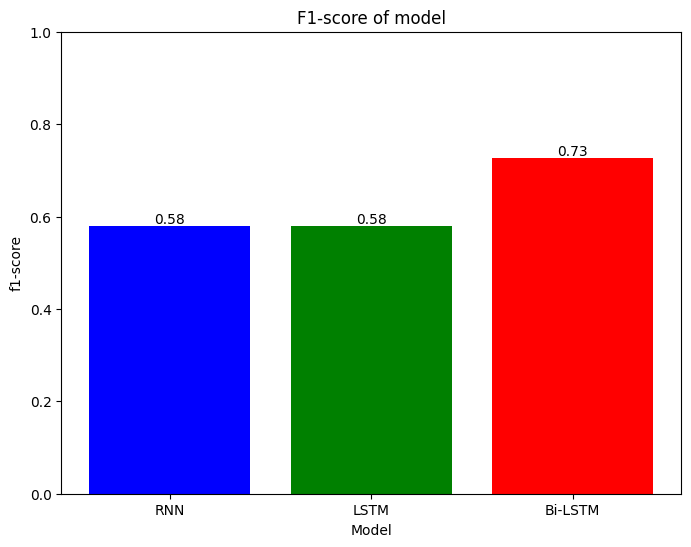

In [44]:
plt.figure(figsize=(8, 6))
bars = plt.bar(result['model'], result['f1-score'], color=['blue', 'green', 'red'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('f1-score')
plt.title('F1-score of model')
plt.ylim(0, 1)
plt.show()